# Lecture 2b: Classical spins on a lattice

In this second part of Lecture 2, we will delve into a physics example: classical spins on a 2D lattice (see lecture notes). We will use some datasets generated in class, and we will try to predict critical temperature by implementing numerical simulations. We will then compare the results obtained to the analytical predictions.

First, we need to import some previously generated spin configurations and we will do some *data analysis* on these datasets to make them suitable for our task.

In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import ellipk

In [2]:
def m_analytical(T,T_c):
    val = 0
    if (T<=T_c):
        val = (1-np.sinh(2.0/T)**(-4))**(1.0/8.0)
    else:
        val=0
    return val

def energy_analytical(T):
    """
    Compute the mean energy per spin E(T) for the 2D Ising model based on Onsager's solution.

    Parameters:
    ----------
    T : float or np.ndarray
        Temperature(s) at which to compute the mean energy per spin.
    J : float, optional
        Exchange interaction constant. Default is 1.0.

    Returns:
    -------
    E_T : float or np.ndarray
        Mean energy per spin corresponding to each temperature in T.
    """
    # Ensure T is a NumPy array for vectorized operations
    T = np.array(T, dtype=np.float64)

    # Avoid division by zero by setting a minimum temperature
    T = np.where(T <= 0, 1e-10, T)
    J = 1
    # Compute k = 2 * sinh(2J/T) / cosh^2(2J/T)
    sinh_term = np.sinh(2.0 * J / T)
    cosh_term = np.cosh(2.0 * J / T)
    k = (2.0 * sinh_term) / (cosh_term ** 2)

    # Compute k squared for the elliptic integral
    m = k ** 2

    # Compute the complete elliptic integral of the first kind, K(k)
    # scipy.special.ellipk takes m = k^2 as input
    K = ellipk(m)

    # Compute tanh(2J/T)
    tanh_2J_over_T = np.tanh(2.0 * J / T)

    # Compute coth(2J/T) = 1 / tanh(2J/T)
    coth_2J_over_T = 1.0 / tanh_2J_over_T

    # Compute the mean energy per spin using the corrected Onsager's formula
    E_T = -J * coth_2J_over_T * (
        1.0 + (2.0 / np.pi) * (2.0 * tanh_2J_over_T**2 - 1.0) * K
    )

    return E_T

In [3]:
import os
import re

In [13]:
# Define the folder path
L_vec = [5, 10, 20, 30, 40, 50, 60]

for L in L_vec:
    folder_path = r"..\data\Lecture2b-data\data_spins_configurations_L.{:03d}/".format(L)

    dataframes = []
    
 
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file matches the naming pattern
        if filename.startswith("dataset_Ising_2D_") and filename.endswith(".pkl"):
            # Use regex to extract L and T
            match = re.search(r"L#(\d+)_T#([\d\.]+)", filename)
            if match:
                try:
                    # Extract L and T
                    L = int(match.group(1))       # Lattice size
                    T = float(match.group(2).strip('.'))  # Temperature
    
                    # Construct full file path
                    file_path = os.path.join(folder_path, filename)
    
                    # Read the pickle file into a DataFrame
                    df = pd.read_pickle(file_path)
    
                    # # Add metadata columns for L and T
                    # df['L'] = L
                    # df['T'] = T
    
                    # Append to the list of DataFrames
                    dataframes.append(df)
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")
    
    # Concatenate all DataFrames into a single DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print("Combined DataFrame created successfully!")
    else:
        print("No valid dataframes found.")
    
    # Display the combined DataFrame
    print(combined_df.head())
    
    pd.to_pickle(combined_df, r"../data/Lecture2b-data/dataset_L.{:03d}.pkl".format(L))

Combined DataFrame created successfully!
   L    T  beta  N_metropolis  sampling_interval  idx_sample  \
0  5  1.0   1.0          3000                300           0   
1  5  1.0   1.0          3000                300           1   
2  5  1.0   1.0          3000                300           2   
3  5  1.0   1.0          3000                300           3   
4  5  1.0   1.0          3000                300           4   

                                             lattice  E_per_spin  M_per_spin  
0  [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1...        -2.0         1.0  
1  [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1...        -2.0         1.0  
2  [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1...        -2.0         1.0  
3  [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1...        -2.0         1.0  
4  [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1...        -2.0         1.0  
Combined DataFrame created successfully!
    L    T  beta  N_metropolis  sampling_interval  idx_samp

In [14]:
from itertools import cycle

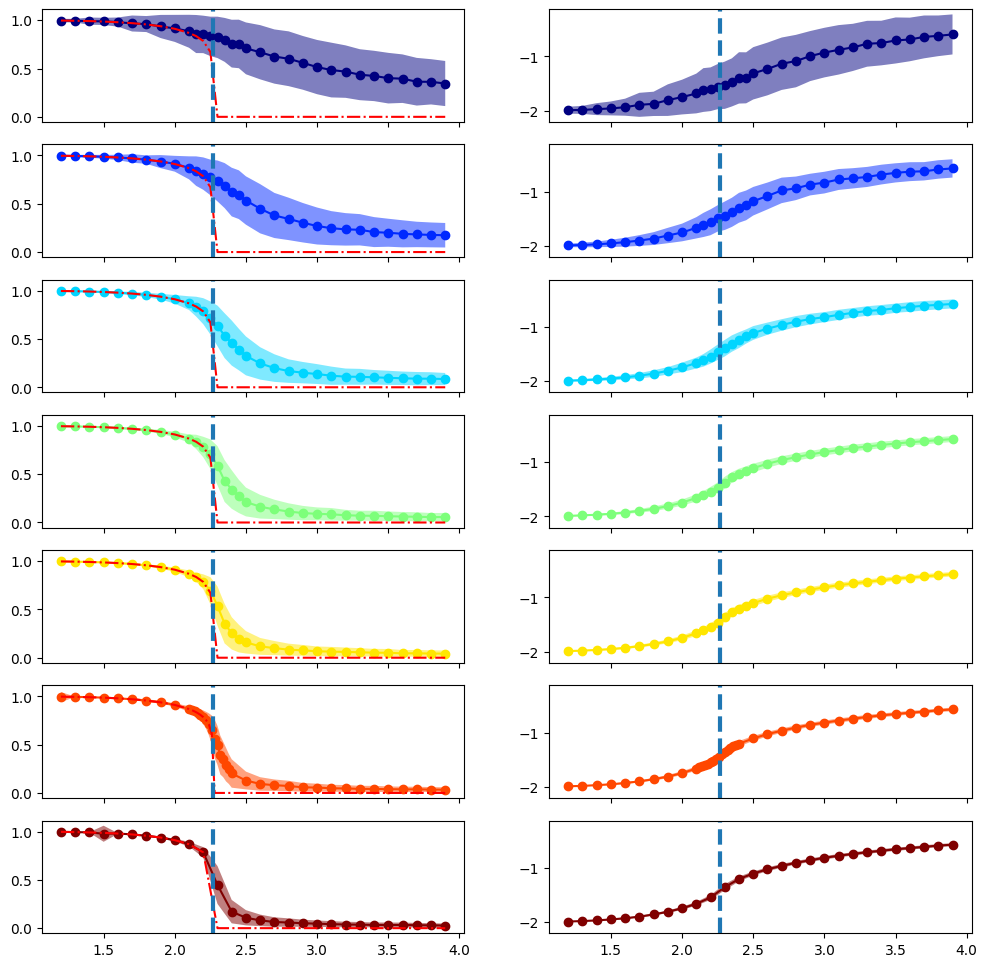

In [17]:
ntraj=10
n=20
p=0.4

N_L = len(L_vec)

colors = plt.cm.jet(np.linspace(0,1,N_L))

fig, ax = plt.subplots(N_L, 2, figsize = (12, 12), sharex = True, sharey = 'col')

T_c = 2./np.log(1+np.sqrt(2))
for L_idx, L in enumerate(L_vec):

    # dataset = pd.DataFrame(dataset)
    combined_df = pd.read_pickle(r"../data/Lecture2b-data/dataset_L.{:03d}.pkl".format(L))
    dataset = combined_df
    
    # cond = dataset["L"] == L
    
    # dataset = dataset[cond]
    T_vec = np.unique(dataset["T"])
    
    M_vs_T_vec = []
    E_vs_T_vec = []
    M_theory_vs_T_vec = []
    for T_idx, T in enumerate(T_vec):
        if(T>1.2 and T<=4.):
            cond_1 = dataset["T"] == T
            
            mean_M = np.mean(dataset[cond_1]["M_per_spin"])
            std_M = np.std(dataset[cond_1]["M_per_spin"])
            mean_E = np.mean(dataset[cond_1]["E_per_spin"])
            std_E = np.std(dataset[cond_1]["E_per_spin"])
            
            M_vs_T_vec.append([T, mean_M, std_M])
            E_vs_T_vec.append([T, mean_E, std_E])
    
    
            M_theory_vs_T_vec.append([T, m_analytical(T, T_c)])
    
    M_vs_T = np.array(M_vs_T_vec)
    E_vs_T = np.array(E_vs_T_vec)
    M_theory_vs_T_vec = np.array(M_theory_vs_T_vec)
    
    x = M_vs_T[:,0]
    y = M_vs_T[:,1]
    dy = M_vs_T[:,2]
    ax[L_idx,0].plot(x, y, '-o', color=colors[L_idx])
    ax[L_idx,0].fill_between(x, y - dy, y + dy, alpha=0.5,  facecolor= colors[L_idx],
    linewidth=2, linestyle='dashdot', antialiased=True)   
    ax[L_idx, 0].plot(M_theory_vs_T_vec[:, 0], M_theory_vs_T_vec[:, 1], color = 'red', ls = '-.')
    ax[L_idx, 0].axvline(x = T_c, ls = '--', lw = 3)

    x = E_vs_T[:,0]
    y = E_vs_T[:,1]
    dy = E_vs_T[:,2]
    ax[L_idx,1].plot(x, y, '-o', color=colors[L_idx])
    ax[L_idx,1].fill_between(x, y - dy, y + dy,alpha=0.5,  facecolor= colors[L_idx],
    linewidth=2, linestyle='dashdot', antialiased=True)    
    ax[L_idx, 1].axvline(x = T_c, ls = '--', lw = 3)
plt.show() 

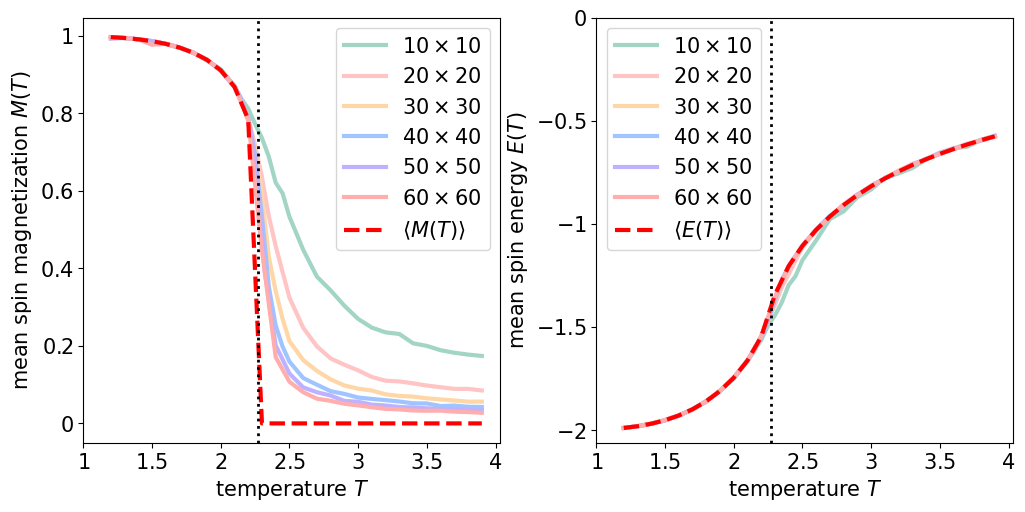

In [18]:
ntraj=10
n=20
p=0.4


FontSize = 15
# L_vec = [8, 32]
N_L = len(L_vec)

# colors=['red', 'blue', 'green', 'magenta', 'brown']
 
colors = [
    '#FFB3BA',  # Pastel pink
    '#FFDFBA',  # Pastel peach
    # '#FFFFBA',  # Pastel yellow
    '#BAFFC9',  # Pastel green
    '#BAE1FF',  # Pastel blue
    '#E3BAFF',  # Pastel lavender
    '#FFD1DC',  # Pastel rose
    '#C4FAF8',  # Pastel aqua
    '#FFCCE5',  # Pastel blush
    '#F3E5AB',  # Pastel sand
]

colors = [
    '#A2D5C6',  # Pastel mint
    '#FFC4C4',  # Pastel light pink
    '#FFD6A5',  # Pastel orange
    # '#FDFFB6',  # Pastel light yellow
    '#A0C4FF',  # Pastel sky blue
    '#BDB2FF',  # Pastel purple
    '#FFADAD',  # Pastel coral
    '#D4A5A5',  # Pastel mauve
    '#E2F0CB',  # Pastel lime
    '#FFE5D9',  # Pastel peach blush
]

fig, ax = plt.subplots(1, 2, figsize = (12, 5), sharex = True, sharey = 'col')

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.23   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax[0].tick_params(axis='both', which='major', labelsize=FontSize)
ax[1].tick_params(axis='both', which='major', labelsize=FontSize)

T_c = 2./np.log(1+np.sqrt(2))
L_vec = [10, 20, 30, 40, 50, 60]
for L_idx, L in enumerate(L_vec):
    # dataset = pd.DataFrame(dataset)
    combined_df = pd.read_pickle(r"../data/Lecture2b-data/dataset_L.{:03d}.pkl".format(L))

    # dataset = pd.DataFrame(dataset)
    dataset = combined_df
    T_vec = np.unique(dataset["T"])    
    M_vs_T_vec = []
    E_vs_T_vec = []
    M_theory_vs_T_vec = []
    E_theory_vs_T_vec = []
    for T_idx, T in enumerate(T_vec):
        if(T>1.2):
            cond_1 = dataset["T"] == T 
            cond_2 = dataset["L"] == L
            
            cond_1 = cond_1 & cond_2
            mean_M = np.mean(dataset[cond_1]["M_per_spin"])
            std_M = np.std(dataset[cond_1]["M_per_spin"])
            mean_E = np.mean(dataset[cond_1]["E_per_spin"])
            std_E = np.std(dataset[cond_1]["E_per_spin"])            
            M_vs_T_vec.append([T, mean_M, std_M])
            E_vs_T_vec.append([T, mean_E, std_E])    
            M_theory_vs_T_vec.append([T, m_analytical(T, T_c)])
            E_theory_vs_T_vec.append([T, energy_analytical(T)])
    
    M_vs_T = np.array(M_vs_T_vec)
    E_vs_T = np.array(E_vs_T_vec)
    M_theory_vs_T_vec = np.array(M_theory_vs_T_vec)
    E_theory_vs_T_vec = np.array(E_theory_vs_T_vec)
    
    x = M_vs_T[:,0]
    y = M_vs_T[:,1]
    dy = M_vs_T[:,2]
    ax[0].plot(x, y, lw = 3, color=colors[L_idx], label = r"${:d}\times{:d}$".format(L, L))
    # ax[0].fill_between(x, y - dy, y + dy, alpha=0.2,  facecolor= colors[L_idx],
    # linewidth=2, linestyle='dashdot', antialiased=True)   

    x = E_vs_T[:,0]
    y = E_vs_T[:,1]
    dy = E_vs_T[:,2]
    ax[1].plot(x, y, lw = 3, color=colors[L_idx], label = r"${:d}\times{:d}$".format(L, L))    
    # ax[1].fill_between(x, y - dy, y + dy, alpha=0.2,  facecolor= colors[L_idx],
    # linewidth=2, linestyle='dashdot', antialiased=True)   
    
   
ax[0].plot(M_theory_vs_T_vec[:, 0], M_theory_vs_T_vec[:, 1], color = 'red', ls = '--', lw = 3 , label = r"$\langle M(T)\rangle$")
ax[1].plot(E_theory_vs_T_vec[:, 0], E_theory_vs_T_vec[:, 1], color = 'red', ls = '--', lw = 3 , label = r"$\langle E(T)\rangle$")


ax[1].axvline(x = T_c, ls = 'dotted', color = 'black', lw = 2) 
ax[0].axvline(x = T_c, ls = 'dotted', color = 'black', lw = 2)




ax[0].legend(fontsize=FontSize)
ax[1].legend(fontsize=FontSize)
ax[0].set_xlabel(r"temperature $T$", fontsize = FontSize)    
ax[1].set_xlabel(r"temperature $T$", fontsize = FontSize)    
ax[0].set_ylabel(r"mean spin magnetization $M(T)$",fontsize = FontSize)    
ax[1].set_ylabel(r"mean spin energy $E(T)$", fontsize = FontSize)    

ax[0].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4], [r"$1$", r"$1.5$", r"$2$", r"$2.5$", r"$3$", r"$3.5$", r"$4$"])
ax[1].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4], [r"$1$", r"$1.5$", r"$2$", r"$2.5$", r"$3$", r"$3.5$", r"$4$"])


ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [r"$0$", r"$0.2$", r"$0.4$", r"$0.6$", r"$0.8$", r"$1$"])
ax[1].set_yticks([-2, -1.5, -1, -0.5, 0], [r"$-2$", r"$-1.5$", r"$-1$", r"$-0.5$", r"$0$"])

plt.show()

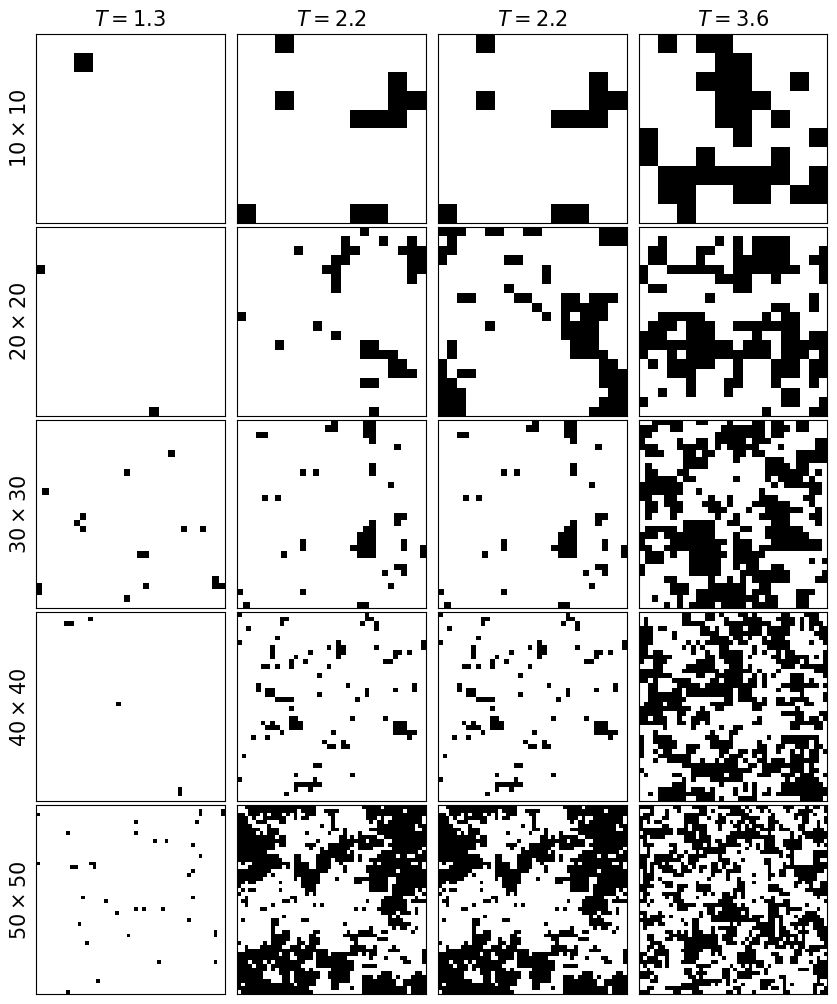

In [19]:
FontSize = 15
L_vec = [10, 20, 30, 40, 50]
N_L = len(L_vec)
colors = plt.cm.jet(np.linspace(0,1,N_L))
T_vec_ = [1.5, 2.2, 2.3, 3.4]
T_vec__ = []
N_T_ = len(T_vec_)
fig, ax = plt.subplots(N_L, N_T_, figsize = (10, 12))
T_c = 2./np.log(1+np.sqrt(2))
for L_idx, L in enumerate(L_vec):
    combined_df = pd.read_pickle(r"../data/Lecture2b-data/dataset_L.{:03d}.pkl".format(L))
    dataset = combined_df 
    M_vs_T_vec = []
    E_vs_T_vec = []
    M_theory_vs_T_vec = []
    for T_idx, T in enumerate(T_vec_):        
        ax[L_idx, 0].set_ylabel(r"${:d} \times {:d}$".format(L, L), fontsize = FontSize)        
        cond_1 = np.abs(dataset["T"] - T)<0.3
        data_ = dataset[cond_1]
        data_ = data_[data_['lattice'].apply(lambda spin_configurations: np.mean(spin_configurations) > 0)]  
        idx = np.random.choice(range(0, len(data_)))
        lattice_configuration = data_['lattice'].values[idx]
        lattice_T = data_['T'].values[idx]
        T_vec__.append(lattice_T)
        ax[L_idx, T_idx].imshow(lattice_configuration, cmap='gray')
        ax[L_idx, T_idx].set_xticks([])
        ax[L_idx, T_idx].set_yticks([])        


ax[0, 0].set_title(r"$T = {:2.1f}$".format(T_vec__[0]), fontsize = FontSize)
ax[0, 1].set_title(r"$T = {:2.1f}$".format(T_vec__[1]), fontsize = FontSize)
ax[0, 2].set_title(r"$T = {:2.1f}$".format(T_vec__[2]), fontsize = FontSize)
ax[0, 3].set_title(r"$T = {:2.1f}$".format(T_vec__[3]), fontsize = FontSize)
plt.subplots_adjust(
    left=0.1,   # Space from left of figure to subplots
    right=0.9,  # Space from right of figure to subplots
    top=0.9,    # Space from top of figure to subplots
    bottom=0.1, # Space from bottom of figure to subplots
    wspace=0.02, # Horizontal space between subplots
    hspace=0.02  # Vertical space between subplots
    )     

plt.show()

Now that we have generated and visualized the datasets, we will use CNNs to predict the critical temperature. 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from matplotlib.colors import ListedColormap, BoundaryNorm


In [21]:
# Load the dataset
L = 50 # Replace with the appropriate value of L
df = pd.read_pickle(r"../data/Lecture2b-data/dataset_L.{:03d}.pkl".format(L))

# Define T_min and T_max
T_min = 1.5
T_max = 3

# Assign labels to the 'y' column based on conditions
df["y"] = np.where(
    df["T"] < T_min, 0,  # Label 0 for T < T_min
    np.where(
        df["T"] > T_max, 1, None  # Label 1 for T > T_max, None otherwise
    )
)

# Filter rows where 'y' is 0 or 1
data = df[df["y"].isin([0, 1])]

# Select only the 'lattice' and 'y' columns
data = data[["lattice", "y"]]

# Reset the index of the filtered DataFrame
data = data.reset_index(drop=True)

# Rename column 'lattice' to 'X'
data = data.rename(columns={"lattice": "X"})

# Split the data into features (X) and labels (y)
X = np.array([np.array(x) for x in data["X"]])  # Convert lists in 'X' to numpy arrays
y = data["y"]  # Labels

# Split the data into training and testing sets with a specified ratio (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Reshape X_train and X_test for CNN input
X_train = X_train.reshape(-1, L, L, 1)  # Adding channel dimension
X_test = X_test.reshape(-1, L, L, 1)

# One-hot encode y_train and y_test
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = encoder.transform(np.array(y_test).reshape(-1, 1))

# Display dataset shapes
print(f"X_train shape: {X_train.shape}, y_train_encoded shape: {y_train_encoded.shape}")
print(f"X_test shape: {X_test.shape}, y_test_encoded shape: {y_test_encoded.shape}")

X_train shape: (12000, 50, 50, 1), y_train_encoded shape: (12000, 2)
X_test shape: (3000, 50, 50, 1), y_test_encoded shape: (3000, 2)


In [22]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(L, L, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')  # Output layer with softmax
])

# Compile the model
model.compile(optimizer=Adam(), 
              loss=CategoricalCrossentropy(), 
              metrics=['accuracy'])

# Train the CNN
history = model.fit(X_train, y_train_encoded, 
                    validation_data=(X_test, y_test_encoded), 
                    epochs=5, 
                    batch_size=64)
 


c:\Users\pablo\OneDrive\Documentos\Master\Machine Learning\DeepLearning-MQST\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.9406 - loss: 0.0904 - val_accuracy: 1.0000 - val_loss: 9.0591e-07
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 1.0000 - loss: 8.2120e-07 - val_accuracy: 1.0000 - val_loss: 5.9652e-07
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 1.0000 - loss: 5.3567e-07 - val_accuracy: 1.0000 - val_loss: 3.9001e-07
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 1.0000 - loss: 3.5266e-07 - val_accuracy: 1.0000 - val_loss: 2.7104e-07
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 1.0000 - loss: 2.4056e-07 - val_accuracy: 1.0000 - val_loss: 1.9141e-07


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


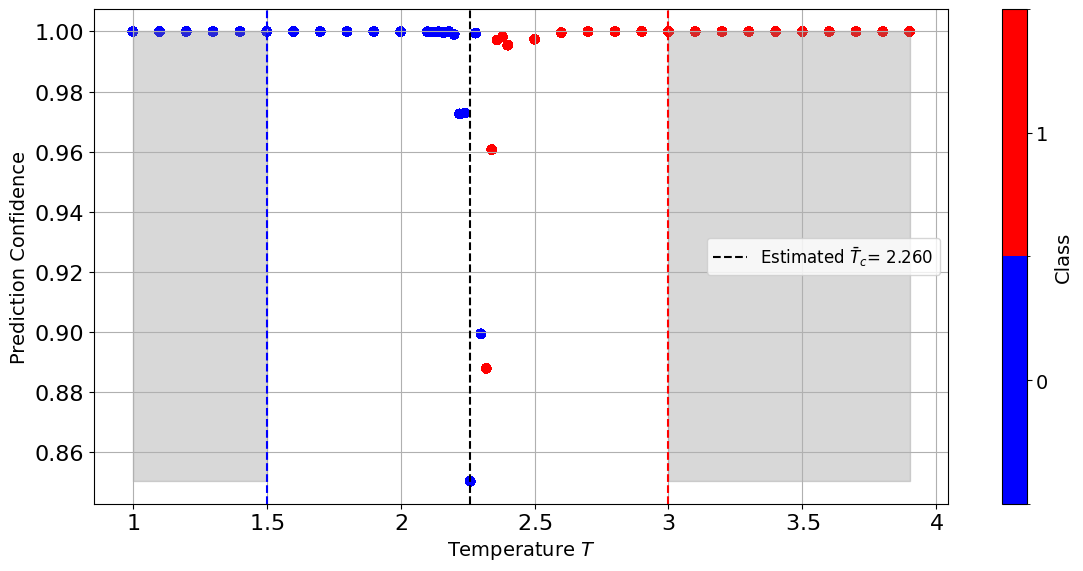

In [23]:
plt.rcParams.update({
    'font.size': 18,          # Base font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 16,     # Axis label font size
    'xtick.labelsize': 16,    # X-axis tick label size
    'ytick.labelsize': 16,    # Y-axis tick label size
    'legend.fontsize': 16     # Legend font size
})



# Ensure lattice data is reshaped for the CNN (add channel dimension for grayscale)
L = df["lattice"].iloc[0].shape[0]  # Assuming all lattices are LxL matrices
X_data = np.array([np.array(lattice).reshape(L, L, 1) for lattice in df["lattice"]])
T_data = df["T"].values  # Extract T values

# Define prediction with confidence function (if not defined earlier)
def predict_with_confidence(model, X):
    """
    Predicts class and confidence for each input in X.

    Args:
        model: Trained Keras model.
        X: Input data (LxL matrices, shape: (samples, L, L, 1)).

    Returns:
        predictions: List of predicted classes.
        confidences: List of confidence scores.
    """
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    confidences = np.max(predictions, axis=1)
    return predicted_classes, confidences

# Make predictions for the entire dataset
pred_classes, pred_confidences = predict_with_confidence(model, X_data)



# Create a DataFrame for easier manipulation
confidence_data = pd.DataFrame({
    "T": T_data,
    "confidence": pred_confidences
})

# Sort by T
confidence_data = confidence_data.sort_values(by="T").reset_index(drop=True)
 
 

T_c_index = confidence_data["confidence"].idxmin()
T_c = confidence_data.loc[T_c_index, "T"]
 
 

#%%
 
plt.rcParams.update({
    'font.size': 16,          # Base font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 16,     # Axis label font size
    'xtick.labelsize': 16,    # X-axis tick label size
    'ytick.labelsize': 16,    # Y-axis tick label size
    'legend.fontsize': 16     # Legend font size
}) 
 
colors = ['blue', 'red']  # Blue for 0, red for 1
cmap = ListedColormap(colors)
boundaries = [-0.5, 0.5, 1]  # Boundaries for discrete values
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=False)

# Set font size for labels and titles
FontSize = 14

# Plot prediction confidence vs T
sc = ax.scatter(T_data, pred_confidences, c=pred_classes, cmap=cmap, norm=norm)
cbar = fig.colorbar(sc, ax=ax)  # Add the colorbar to ax
cbar.set_label("Class", fontsize=FontSize)
cbar.set_ticks([0, 0.75])  # Set ticks for discrete values
cbar.set_ticklabels(['0', '1'], fontsize = FontSize)  # Add labels for clarity

# Customize the plot
ax.set_xlabel(r"Temperature $T$", fontsize=FontSize)
ax.set_ylabel("Prediction Confidence", fontsize=FontSize)
ax.axvline(x=T_c, color="black", linestyle="--", label=r"Estimated $\bar{T}_c$" + "= {:2.3f}".format(T_c))

ax.axvline(x=T_min, color="blue", linestyle="--")
ax.axvline(x=T_max, color="red", linestyle="--")
# Add transparent gray areas
ax.fill_betweenx([1*min(confidence_data["confidence"]), 1], 1.0, T_min, color='gray', alpha=0.3)  # Left of T_min
ax.fill_betweenx([1*min(confidence_data["confidence"]), 1], T_max,  3.9, color='gray', alpha=0.3)  # Right of T_max

ax.set_xticks([1, 1.5, 2, 2.5, 3., 3.5, 4], ["$1$", "$1.5$", "$2$", "$2.5$", "$3$", "$3.5$", "$4$"])
ax.grid(True)  # Enable grid
ax.legend(fontsize=12)
 

# General layout
plt.tight_layout()
plt.show()

The analytical result is Tc ~ 2.269, which means that we obtained a pretty accurate estimation! The question is: did we "discover" anything? Not really, we have just predicted a value, but there is no real knowledge behind this (see lecture notes).